In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import sys, os
from sklearn.model_selection import train_test_split as tts
from scipy.ndimage import uniform_filter1d
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.getcwd())
import models


In [2]:
# Import the keys
keys = list(np.load("keys/all_keys.npy"))
keys = [tuple(k) for k in keys]

# Import the data and labels
mi_matrices = {
    key:np.load(f"MI_matrices/MI_matrix_{key}.npy") for key in keys
}
data = {
    key:np.load(f"data/data_{key}.npy") for key in keys
}

# Sort data into a list, with the same ordering as the MI_matrices
mi_matrices_list = list()
data_list = list()
for key in keys:
    mi_matrices_list.append(mi_matrices[key])
    data_list.append(data[key])

In [3]:
# Hyperparams
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 14
learning_rate = 0.00001
num_epochs = 500
input_size = 5000

In [4]:
# Numpify the data
data = np.asarray(data_list).reshape((48, 5000, 11))
labels = np.array(mi_matrices_list).reshape((48, 11, 11))

# Split the data into train and test
data_train, data_test, label_train, label_test = tts(data, labels, test_size=0.12)

# Modify variable type to tensor
data_train = models.NumbersDataset(data_train, label_train)
data_test = models.NumbersDataset(data_test, label_test)

# Create the dataloaders
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [5]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.l1 = nn.Linear(input_size*11, 64)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(64, 1000)
        self.l3 = nn.Linear(1000, 11*11)

    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out

In [6]:
model = FNN(input_size)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
outs = []
outs_exact = []
loss_train = []
for epoch in range(num_epochs):
    outs = []
    outs_exact = []
    for i, (dat, labs) in enumerate(loader_train):
        labs = labs.reshape(batch_size, -1).to(device)
        sample = dat.reshape(batch_size, -1).to(device)

        # forward
        output = model(sample)
        loss = criterion(output, labs)

        outs_exact += labs.tolist()
        outs += output.tolist()
        loss_train.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"batch {i+1} / {len(loader_train)}")
    
    if epoch % 10 == 0:
        print(f"did {epoch+1} / {num_epochs}")



batch 1 / 3
batch 2 / 3
batch 3 / 3
did 1 / 500
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
did 11 / 500
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
did 21 / 500
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
batch 3 / 3
batch 1 / 3
batch 2 / 3
ba

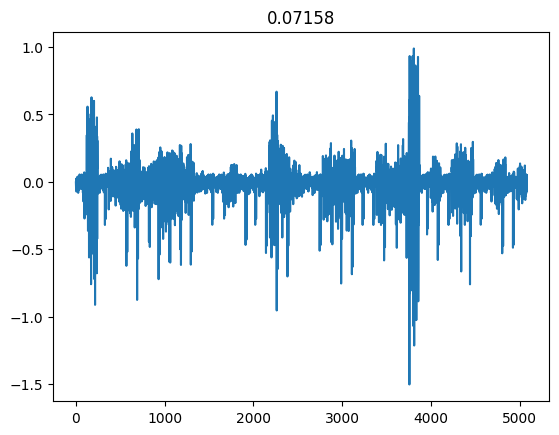

In [7]:
diff = np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1)

plt.plot(diff)
plt.title(f"{np.mean(np.abs(np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1))):.5f}")
plt.show()

In [ ]:
with torch.no_grad():
    out_list = []
    label_list = []
    n_samples = 0
    n_diff = 0